### INTRODUCTION

Crime has always been one of the larger problems in India, especially since it is the second most populous country in the world. Also, some of the cultural peculiarities - sex being a taboo in India, the skewed sex ratio, age-old customs like Sati and Dowry and the lower status women hold in society - cause women to be at higher risk than usual. There is also lack of awareness, inadequate infrastructure and insufficient programs in place for their safety and protection. The problem is most severe in rural areas, but some urban areas like Tier 1 cities, and surprisingly, even the capital, are recognized as high risk zones. In recent times, this has become a matter of great concern after a series of very brutal crimes against young girls have been reported and have made international headlines over the past few years. Safety of women has suddenly become a national priority and is even playing an influential role in the upcoming central elections. These motivations compel us to analyze crime data from India with the goal of gaining an insight into the nature and depth of the problem. We use data from the Open Government Data (OGD) Platform India (http://data.gov.in)

### CODE

In [10]:
%pylab --no-import-all inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
import numpy as np
import os
import pandas as pd
import codecs
import matplotlib.pyplot as plt
import uuid
import jinja2
import folium
import json
import scipy.stats as stats

from itertools import islice
from pandas import DataFrame, Series
from numpy.random import randn
from IPython.display import display, Image, HTML, clear_output
from IPython.html import widgets

# CSS_URL = "http://cdn.leafletjs.com/leaflet-0.7.2/leaflet.css"
# LEAFLET_JS_URL = "http://cdn.leafletjs.com/leaflet-0.7.2/leaflet"

DATA RETRIEVAL

We start by importing the data from the csv data files. We then create data frames that we will use to analyze data for the current year.

In [12]:
# Set the path to get the files to be the base directory of the application
FILES_DIR = os.path.join(os.pardir, "_data")

# Open the file with current year statistics and create a data frame
currentFile = codecs.open(os.path.join(FILES_DIR,'CurrentYear2012Data.csv'), encoding='iso-8859-1')
currentYear = DataFrame(pd.read_csv(currentFile))

# Remove summary (total) rows from the data
currentYear = currentYear[(currentYear['STATE/UT'] != 'TOTAL (UTs)') & (currentYear['STATE/UT'] != 'TOTAL (STATES)') & (currentYear['STATE/UT'] != 'TOTAL (ALL-INDIA)')]
currentYear = currentYear[(currentYear['Crime head'] != 'TOTAL CRIMES AGAINST WOMEN')]

# Open the file with current year population and create a data frame
currentFile = codecs.open(os.path.join(FILES_DIR,'indiaStatesPopulation.csv'), encoding='iso-8859-1')
currentPopulation = DataFrame(pd.read_csv(currentFile))

# Merge the two dataframes to create a dataframe with current year statistics and population.
currentYear = DataFrame(pd.merge(currentYear, currentPopulation, on='STATE/UT'))

#Open the file with historic crime type
currentFile = codecs.open(os.path.join(FILES_DIR,'historicCrimeTypeYearly.csv'), encoding='iso-8859-1')
historicCrimes = DataFrame(pd.read_csv(currentFile))
historicCrimes = historicCrimes[(historicCrimes['CRIME HEAD'] != 'Total Crimes against Women')]

#Open the file with historic crime type and Create the data frame
currentFile = codecs.open(os.path.join(FILES_DIR,'literacy_rate_2011.csv'), encoding='iso-8859-1')
literacyRates = DataFrame(pd.read_csv(currentFile))

#Open the file with charges and convictions for 2010 - 2012
currentFile = codecs.open(os.path.join(FILES_DIR,'CasesPersonsHeldUnderCAW2010-2012.csv'), encoding='iso-8859-1')
Year2010_2012 = DataFrame(pd.read_csv(currentFile))
Year2010_2012 = Year2010_2012[Year2010_2012["CRIME HEAD"] != "TOTAL CRIMES AGAINST WOMEN"]
newdf = Year2010_2012[(Year2010_2012['STATE/UT'] != "TOTAL (STATES)") & (Year2010_2012['STATE/UT'] != "TOTAL (UTs)") & (Year2010_2012['STATE/UT'] != "TOTAL (ALL-INDIA)")]
arrestCharges = Year2010_2012[['STATE/UT', 'CRIME HEAD', 'CASES REGISTERED - 2010', 'CASES CHARGESHEETED - 2010', 'CASES CONVICTED - 2010', 'CASES REGISTERED - 2011', 'CASES CHARGESHEETED - 2011', 'CASES CONVICTED - 2011', 'CASES REGISTERED - 2012', 'CASES CHARGESHEETED - 2012', 'CASES CONVICTED - 2012']]

#Open the file with charges and convictions for 2010 - 2012
currentFile = codecs.open(os.path.join(FILES_DIR,'CasesRegisteredAndTheirDisposalUnderCrimeAgainstWomen2012.csv'), encoding='iso-8859-1')
allCases = DataFrame(pd.read_csv(currentFile))
allCases = allCases[(allCases['STATE/UT'] != "TOTAL (STATES)") & (allCases['STATE/UT'] != "TOTAL (UTs)") & (allCases['STATE/UT'] != "TOTAL (ALL-INDIA)")]


CURRENT YEAR ANALYSIS

Our initial analysis, focuses on the current crime numbers for the year 2012. 

In [13]:
#Total Crimes Against Women in 2012
print(sum(currentYear['Grand Total']))

433663


A total 433663 crimes against women were reported in the year 2012. 



In [14]:
stateNumbers = currentYear.groupby('STATE/UT').sum()

stateNumbers = stateNumbers.sort(['Grand Total'], ascending=[0])
stateNumbers = stateNumbers[["Total Male", "Total Female", "Grand Total", "Total population"]]
stateNumbers = stateNumbers.loc[["ANDHRA PRADESH", "MEGHALAYA", "KARNATAKA","GOA",
                                                              "GUJARAT", "HARYANA", "NCT OF DELHI", "WEST BENGAL"]]
stateNumbers

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  This is separate from the ipykernel package so we can avoid doing imports until


,Total Male,Total Female,Grand Total,Total population
STATE/UT,,,,
ANDHRA PRADESH,64916,13660,78576,1015986396
MEGHALAYA,252,19,271,32604077
KARNATAKA,12946,3734,16680,672437744
GOA,234,52,286,16034953
GUJARAT,18026,5939,23965,664219908
HARYANA,6268,996,7264,278883891
NCT OF DELHI,3657,324,3981,184285585
WEST BENGAL,25332,8691,34023,1004825096


Preliminary Analysis To Do

We attempt to calculate the total number of people (men and women) arrested for crime against women in 2012 by summing up the Grand Total column. Further, we try to find the total number of these criminals per thousand. Turns out, about 1 in every thousand people got arrested for commiting a crime against women. This is a big number for a country with a population of over a billion.  

In [15]:
stateNumbers[['Grand Total', 'Total population']] = stateNumbers[['Grand Total', 'Total population']].astype(float)


# stateNumbers['weightedCrime'] = stateNumbers.apply(lambda return x: Grand Total,axis=1)
stateNumbers['Weighted Crime'] = stateNumbers.apply(lambda s: (s['Grand Total'] *100000) / s['Total population'], axis=1)

totalCrime_2012 = sum(stateNumbers['Grand Total'])
totalPopulation_2012 = sum(stateNumbers['Total population'])

criminalsPer_1000 = (totalCrime_2012 / totalPopulation_2012) * 1000

In [16]:
stateNumbers

,Total Male,Total Female,Grand Total,Total population,Weighted Crime
STATE/UT,,,,,
ANDHRA PRADESH,64916,13660,78576.0,1.015986e+09,7.733962
MEGHALAYA,252,19,271.0,3.260408e+07,0.831184
KARNATAKA,12946,3734,16680.0,6.724377e+08,2.480527
GOA,234,52,286.0,1.603495e+07,1.783604
GUJARAT,18026,5939,23965.0,6.642199e+08,3.607992
HARYANA,6268,996,7264.0,2.788839e+08,2.604668
NCT OF DELHI,3657,324,3981.0,1.842856e+08,2.160234
WEST BENGAL,25332,8691,34023.0,1.004825e+09,3.385962


Normalized Crime Per State

We now want to see how the states rank in terms of crimes relative to their populations. Do they rank similarly or they follow a similar pattern in terms of number of crimes 

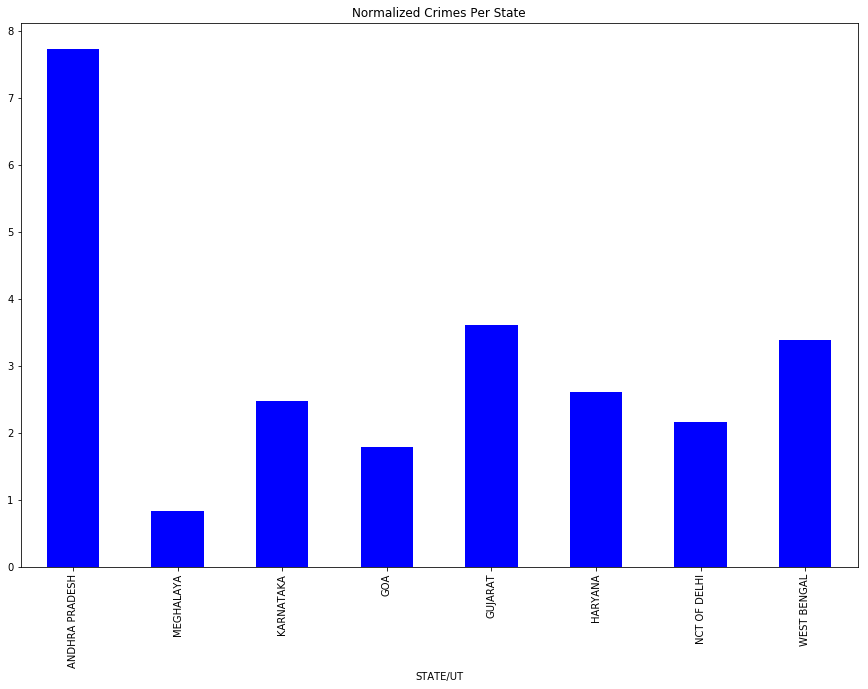

In [17]:
weightedStateNumbers= stateNumbers
plt.figure
weightedStateNumbers['Weighted Crime'].plot(kind='bar', figsize=(15,10), title = 'Normalized Crimes Per State', color='b')
# weightedStateNumbers['STATE/UT']

### CONVICTIONS

Is There Any Action Being Taken Against Offenders: How Many Cases Or People Are Being Charged as compared those that are actually being convicted.

In [18]:
print (sum(Year2010_2012['PERSONS CONVICTED - 2012']).astype(float) / sum(Year2010_2012['PERSONS CHARGESHEETED - 2012']).astype(float)) * 100

0.127984894722


TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [19]:
Year2010_2012 = Year2010_2012.loc[Year2010_2012["STATE/UT"].isin(["ANDHRA PRADESH", "MEGHALAYA", "KARNATAKA","GOA",
                                                             "GUJARAT", "HARYANA", "NCT OF DELHI", "WEST BENGAL"])]
Year2010_2012 = Year2010_2012.groupby("STATE/UT").sum()
Year2012 = Year2010_2012[['PERSONS ARRESTED - 2012', 'PERSONS CHARGESHEETED - 2012', 'PERSONS CONVICTED - 2012']]
Year2012['PERSONS ACQUITTED - 2012'] = Year2012['PERSONS ARRESTED - 2012'] - Year2012['PERSONS CONVICTED - 2012']
Year2012.columns = ['Persons Arrested', 'Persons Chargesheeted', 'Persons Convicted', 'Persons Acquitted']
Year2012

,Persons Arrested,Persons Chargesheeted,Persons Convicted,Persons Acquitted
STATE/UT,,,,
ANDHRA PRADESH,39288,39191,3527,35761
GOA,286,127,7,279
GUJARAT,23965,23525,434,23531
HARYANA,7264,7429,1266,5998
KARNATAKA,16680,15849,859,15821
MEGHALAYA,271,160,9,262
WEST BENGAL,34023,33694,915,33108


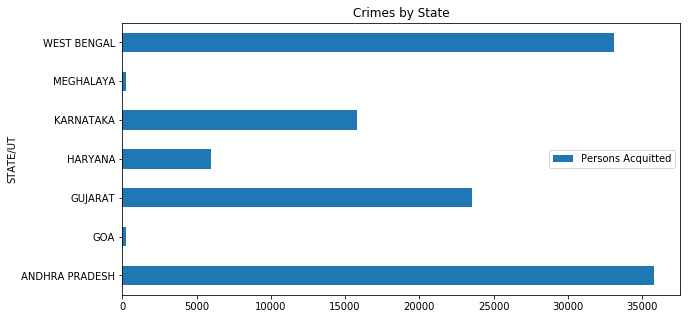

In [22]:
newDF = Year2012[['Persons Acquitted']]
newDF.plot(kind='barh', title="Crimes by State", figsize=(10,5))

In [24]:
newDF['Percentage Acquitted'] = (newDF['Persons Acquitted']/Year2012['Persons Arrested'])*100
newDF[['Percentage Acquitted']]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Percentage Acquitted
STATE/UT,
ANDHRA PRADESH,91.022704
GOA,97.552448
GUJARAT,98.189026
HARYANA,82.571586
KARNATAKA,94.850120
MEGHALAYA,96.678967
WEST BENGAL,97.310643


### Looking for A Correlation Between Crimes and Literacy Rates In States

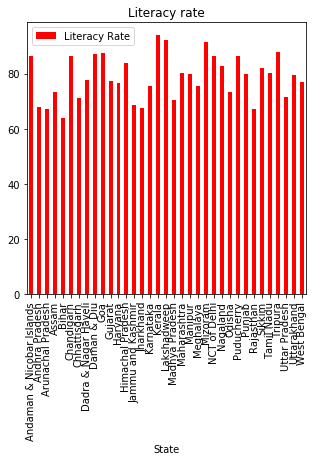

In [25]:
plt.figure
literacyRates= literacyRates.groupby('State').sum()
literacyRates.plot(kind='bar', figsize=(5,5), title = 'Literacy rate', color='red')

In [26]:


weightedStateNumbers['STATE/UT'] = weightedStateNumbers.index
weightedStateNumbers = weightedStateNumbers.sort_index(by="STATE/UT")
crimeArray = np.array(weightedStateNumbers['Weighted Crime'])



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  """


ValueError: operands could not be broadcast together with shapes (35,) (8,) 

In [27]:
weightedStateNumbers = weightedStateNumbers["Weighted Crime"]
weightedStateNumbers = weightedStateNumbers.loc[["ANDHRA PRADESH", "MEGHALAYA", "KARNATAKA","GOA",
                                                             "GUJARAT", "HARYANA", "NCT OF DELHI", "WEST BENGAL"]]
literacyRates = literacyRates.loc[["Andhra Pradesh", "Meghalaya", "Karnataka","Goa", "Gujarat", "Haryana", "NCT of Delhi", "West Bengal"]]
literacyRates = literacyRates.set_index([["ANDHRA PRADESH", "MEGHALAYA", "KARNATAKA","GOA",
                                                             "GUJARAT", "HARYANA", "NCT OF DELHI", "WEST BENGAL"]])
literacyRates["Weighted Crime"] = weightedStateNumbers
literacyRates

,Literacy Rate,Weighted Crime
ANDHRA PRADESH,67.89,7.733962
MEGHALAYA,75.50,0.831184
KARNATAKA,75.60,2.480527
GOA,87.40,1.783604
GUJARAT,77.30,3.607992
HARYANA,76.60,2.604668
NCT OF DELHI,86.30,2.160234
WEST BENGAL,77.10,3.385962


In [28]:
# Calcualate the Correlation Coefficient For the Crime and Literacy 

literacyArray = np.array(literacyRates['Literacy Rate'])
crimeArray = np.array(literacyRates['Weighted Crime'])
stats.pearsonr(literacyArray, crimeArray)

(-0.65643869310406189, 0.077052346354637424)

### Conclusion

Our null hypothesis is that literacy and crime rate should be negatively correlated: higher education should lead to lesser crimes. 
Finding out Pearson's correlation co-efficient and the p value, we find that the two variables are indeed negatively correlated. The p value being 0.09 (>0.05) we fail to reject the null hypothesis, leading us to believe that there is indeed some correlation between crimes and literacy. However, this seems to be more of a loose correlation. 

RESOURCES

http://timesofindia.indiatimes.com/city/pune/Sharp-rise-in-crimes-against-women-in-Pune/articleshow/31076736.cms
http://timesofindia.indiatimes.com/city/nashik/Nashik-records-sharp-increase-in-crime-against-women/articleshow/31625201.cms
http://timesofindia.indiatimes.com/city/delhi/man-held-for-molesting-19-year-old/articleshow/30647617.cms
http://timesofindia.indiatimes.com/india/Map-crimes-against-women-High-court/articleshow/31915637.cms
http://ibnlive.in.com/news/bank-clerk-arrested-for-raping-woman-on-marriage-pretext/469552-3-236.html
http://ibnlive.in.com/news/police-official-booked-for-raping-girl-at-gunpoint-in-aligarh/469553-3-242.html
http://ibnlive.in.com/newstopics/crime-against-women.html
http://en.wikipedia.org/wiki/2012_Delhi_gang_rape